In [1]:
import sys
sys.path.append('../../')

In [59]:
%load_ext autoreload
%autoreload 2
from relation import Distribution
from relation import Analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
d = Distribution('')

In [60]:
a = Analysis(50,'140','')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from astropy import units as un, constants as cons
from astropy.cosmology import WMAP7 as cosmo
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from scipy.interpolate import RegularGridInterpolator
from scipy.fftpack import fftn, ifftn, fftfreq

In [3]:
header_cluster = np.array(['UID', 'x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'x_pix', 'y_pix',
                           'i_sector', 'm500c[Msol/h]', 'r500c[kpc/h]', 'gas_frac',
                           'star_frac', 'T[kev]', 'Lx[1e44erg/s]', 'Y500c', 'M_sat/M_cD',
                           'cshift[kpc]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'])

header_galaxy = np.array(['UID', 'x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'x_pix',
                           'y_pix', 'i_sector', 'm[Msol/h]', 'sfr[Msol/year]',
                           'host', 'dist[kpc/h]', 'log10(m_cD/m)', 'm_gas[Msol/h]',
                           'vx[km/s]', 'vy[km/s]', 'vz[km/s]', 'dv[km/s]',
                           'vr[km/s]', 'vt[km/s]'])


In [4]:
clusterfile = np.loadtxt('../../Data/cluster140.txt')
galaxyfile = np.loadtxt('../../Data/galaxies140.txt')

In [5]:
#galaxy positions
h0 = 0.704
z = 0.03 #snap140, box2hr
xg = galaxyfile[:,np.where(header_galaxy=='x[kpc/h]')[0][0]]/h0
yg = galaxyfile[:,np.where(header_galaxy=='y[kpc/h]')[0][0]]/h0
zg = galaxyfile[:,np.where(header_galaxy=='z[kpc/h]')[0][0]]/h0
pos3d_g = np.vstack((xg,yg,zg))

In [6]:
#cluster velocities & positions
xc = clusterfile[:,np.where(header_cluster=='x[kpc/h]')[0][0]]/h0
yc = clusterfile[:,np.where(header_cluster=='y[kpc/h]')[0][0]]/h0
zc = clusterfile[:,np.where(header_cluster=='z[kpc/h]')[0][0]]/h0
pos3d_c = np.vstack((xc,yc,zc))

vx = clusterfile[:,np.where(header_cluster=='vx[km/s]')[0][0]]*1e5 #cm/s
vy = clusterfile[:,np.where(header_cluster=='vy[km/s]')[0][0]]*1e5 #cm/s
vz = clusterfile[:,np.where(header_cluster=='vz[km/s]')[0][0]]*1e5 #cm/s
vnet = np.sqrt(vx**2.+vy**2.+vz**2.) 

In [7]:
boxmin, boxmax,  = 0., 5e5 #in kpc (500Mpc)
nbins = 50
bin_len = boxmax/nbins # kpc

#making sure we have enough resolution
ngalx = len(xg)
box_volume = boxmax**3
bin_volume = bin_len**3
navg = ngalx*bin_volume/box_volume
print ('Bin length [Mpc] and avg galaxies per cubic volume =', bin_len/1e3,',', navg)

Bin length [Mpc] and avg galaxies per cubic volume = 10.0 , 10.882456


In [8]:
#counting number of clusters in each voxel
binedges = np.linspace(boxmin,boxmax,nbins+1)
bincenters = 0.5*(binedges[1:]+binedges[:-1])
ret = stats.binned_statistic_dd(pos3d_g.T, None, 'count', 
                                bins=[binedges, binedges, binedges])
Ngalx = ret.statistic

In [9]:
np.mean(Ngalx), np.median(Ngalx), Ngalx.min(), Ngalx.shape

(10.882456, 6.0, 0.0, (50, 50, 50))

In [10]:
def f_growth_fit(Om,Ol):
    return Om**(4./7.)+(1.+Om/2.)*Ol/70.

In [11]:
Om=cosmo.Om0
Ol=1.-Om
print (f_growth_fit(Om,Ol), Om**0.55)

0.48703637686475193 0.48866687103994816


In [13]:
Ngalx_avg = np.mean(Ngalx)
deltag = Ngalx/Ngalx_avg-1.
f_growth = 0.5# approx
H0 = cosmo.H0.to('/s').value
a0 = 1./(1.+z)
bg = 5. #galaxy bias
prefac = -a0*H0*f_growth/bg
deltak = fftn(-a0*H0*f_growth*deltag/bg)

In [74]:
'''# interpolating
itp = RegularGridInterpolator((bincenters,bincenters,bincenters), deltag, method='nearest',
                             bounds_error=False, fill_value=None) 
deltag_itp = itp(pos3d.T)
deltak_itp = fftn(deltag_itp)'''

"# interpolating\nitp = RegularGridInterpolator((bincenters,bincenters,bincenters), deltag, method='nearest',\n                             bounds_error=False, fill_value=None) \ndeltag_itp = itp(pos3d.T)\ndeltak_itp = fftn(deltag_itp)"

In [14]:
freq = fftfreq(nbins, d=bin_len*cons.kpc.to('cm').value)
kx, ky, kz = np.meshgrid(freq, freq, freq, indexing='ij')
k_squared = kx**2 + ky**2 + kz**2
k_squared[0, 0, 0] = 1

In [15]:
#Gaussian filter
R_filter = 2*bin_len*cons.kpc.to('cm').value
Wk = np.exp(-R_filter**2*k_squared/2.)

# Calculating the momentum field (ignoring the factor of -i)
momentum_x = deltak * Wk * kx / k_squared
momentum_y = deltak * Wk * ky / k_squared
momentum_z = deltak * Wk * kz / k_squared

# Inverse Fourier Transform to get velocity field
velocity_x = np.real(ifftn(-1j*momentum_x))
velocity_y = np.real(ifftn(-1j*momentum_y))
velocity_z = np.real(ifftn(-1j*momentum_z))

velocity_x_interpolator = RegularGridInterpolator((bincenters,bincenters,bincenters), 
                                                  velocity_x, bounds_error=False, 
                                                  fill_value=None, method='linear')
velocity_y_interpolator = RegularGridInterpolator((bincenters,bincenters,bincenters), 
                                                  velocity_y, bounds_error=False, 
                                                  fill_value=None, method='linear')
velocity_z_interpolator = RegularGridInterpolator((bincenters,bincenters,bincenters), 
                                                  velocity_z, bounds_error=False, 
                                                  fill_value=None, method='linear')

#interpolating velocities at cluster locations
vx_itp = velocity_x_interpolator(pos3d_c.T)
vy_itp = velocity_y_interpolator(pos3d_c.T)
vz_itp = velocity_z_interpolator(pos3d_c.T)
vnet_itp = np.sqrt(vx_itp**2+vy_itp**2+vz_itp**2)

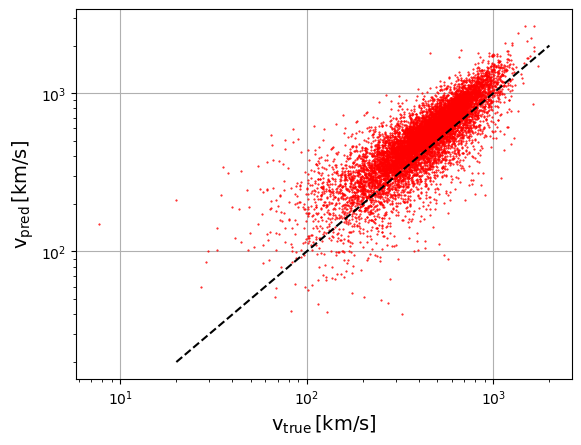

avg correlation = 0.8438810324052577


In [17]:
plt.loglog(vnet/1e5,vnet_itp/1e5,'r.',markersize=1)
plt.xlabel(r'$\rm v_{true}\, [km/s]$', fontsize=14)
plt.ylabel(r'$\rm v_{pred}\, [km/s]$', fontsize=14)
plt.plot([20,2e3],[20,2e3],'k--')
plt.grid()
plt.show()
print ('avg correlation =', np.corrcoef(vnet,vnet_itp)[0][1])

array([[1., 1.],
       [1., 1.]])

In [18]:
plt.plot(vza/1e5,vz/1e5,'r.',markersize=1)
plt.xlabel(r'$\rm v^z_{true}\, [km/s]$', fontsize=14)
plt.ylabel(r'$\rm v^z_{pred}\, [km/s]$', fontsize=14)
#plt.plot([-1e3,1e3],[-1e3,1e3],'k--')
plt.grid()
plt.show()
print ('avg correlation =', np.corrcoef(vz,vz_itp)[0][1])

NameError: name 'vza' is not defined

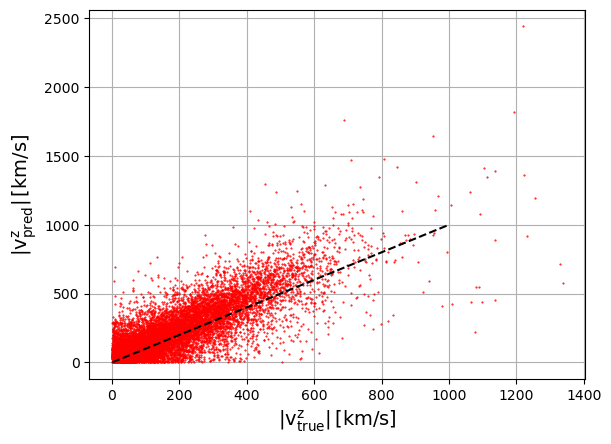

avg correlation = 0.9002092155230014


In [19]:
plt.plot(np.abs(vz)/1e5,np.abs(vz_itp)/1e5,'r.',markersize=1)
plt.xlabel(r'$\rm |v^z_{true}|\, [km/s]$', fontsize=14)
plt.ylabel(r'$\rm |v^z_{pred}|\, [km/s]$', fontsize=14)
plt.plot([1,1e3],[1,1e3],'k--')
plt.grid()
plt.show()
print ('avg correlation =', np.corrcoef(vz,vz_itp)[0][1])

# Yksz scaling

In [20]:
#some handy constants
X = 0.75     # hydrogen mass fraction
mu = 4./(3.+5.*X) # mean molecular weight
mue = 2./(1.+X) # mean molecular weight per electron
muh = 1./X # mean molecular weight per hydrogen 
mp = cons.m_p.to('g').value # proton mass
me = cons.m_e.to('g').value # electron mass
kb = cons.k_B.to('erg / K').value # Boltzmann constant
sigma_T = cons.sigma_T.to('cm^2').value # thompson scattering cross-section
sol_c = cons.c.to('cm/s').value # speed of light
Msun = cons.M_sun.to('g').value # solar mass
Mpc = cons.kpc.to('cm').value*1e3
kev2ergs = 1.60218e-9

In [21]:
Ez = cosmo.H(z)/cosmo.H0 
m500c = clusterfile[:,np.where(header_cluster=='m500c[Msol/h]')[0][0]]/h0
gas_frac = clusterfile[:,np.where(header_cluster=='gas_frac')[0][0]]
star_frac = clusterfile[:,np.where(header_cluster=='star_frac')[0][0]]
mgas = gas_frac*m500c
mstar = star_frac*m500c
tgas = clusterfile[:,np.where(header_cluster=='T[kev]')[0][0]]*kev2ergs # ergs
Yksz = np.abs(mgas*Msun*vz*sigma_T/(sol_c*mue*mp*Mpc**2)) # in units mpc^2
Ytsz = mgas*Msun*tgas*sigma_T/(me*sol_c**2*mue*mp*Mpc**2) # in units mpc^2
Nclus = len(m500c)

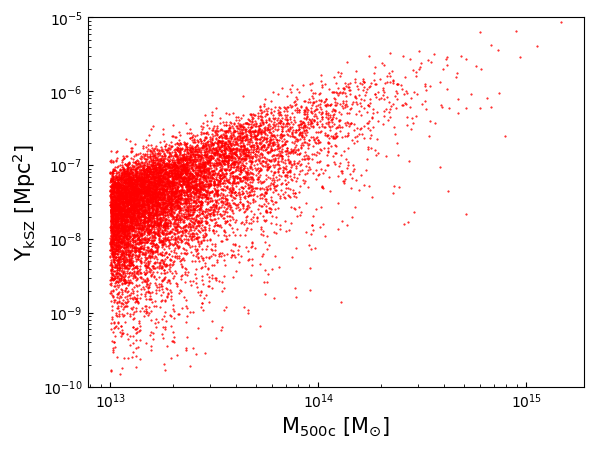

In [22]:
plt.plot(m500c,Yksz,'r.',markersize=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rm M_{500c}\,\, [M_{\odot}]$',fontsize=15)
plt.ylabel(r'$\rm Y_{kSZ}\,\, [Mpc^2]$',fontsize=15)
plt.ylim(1e-10,1e-5)
plt.tick_params(axis="both",direction="in",which="both")
plt.show()

# Power law fit

In [23]:
from scipy.optimize import curve_fit

def power_law(x, norm, alpha): # this is your 'straight line' y=f(x)
    return norm+x*alpha

In [24]:
m500c_med = np.median(m500c)
lnX, lnYksz = np.log(m500c/m500c_med), np.log(Yksz)
fit_ksz, _ = curve_fit(power_law, lnX, lnYksz) 

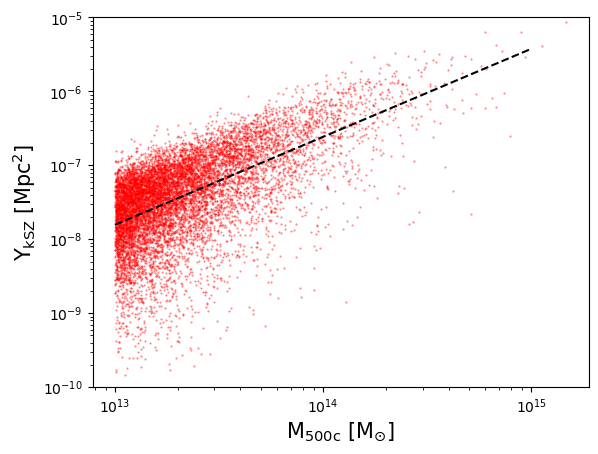

In [25]:
marr = np.linspace(13.,15.,10)
Yksz_p = np.exp(power_law(np.log(10.**marr/m500c_med), fit_ksz[0], fit_ksz[1]))
plt.plot(m500c,Yksz,'r.',markersize=1,alpha=0.5)
plt.plot(10.**marr,Yksz_p,'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rm M_{500c}\,\, [M_{\odot}]$',fontsize=15)
plt.ylabel(r'$\rm Y_{kSZ}\,\, [Mpc^2]$',fontsize=15)
plt.ylim(1e-10,1e-5)
plt.show()

In [26]:
lnYksz_pl = power_law(lnX, fit_ksz[0], fit_ksz[1])
sigma_ksz = np.sqrt(((lnYksz-lnYksz_pl)**2.).sum()/float(Nclus))
print ('log-normal scatter in Yksz-M500c =', sigma_ksz)

log-normal scatter in Yksz-M500c = 1.144756036078561


# Random forest

In [27]:
#all data
lnX = np.vstack([np.log(m500c),np.log(np.abs(vz_itp))]).T
lnYksz = np.log(Yksz)

In [29]:
regr = RandomForestRegressor(max_depth=50, random_state=0,n_estimators=200,n_jobs=-1,
                            max_leaf_nodes=30)
regr.fit(lnX,lnYksz)

RandomForestRegressor(max_depth=50, max_leaf_nodes=30, n_estimators=200,
                      n_jobs=-1, random_state=0)

In [30]:
def lnsigma(Y,Yp):
    return np.sqrt(((Y-Yp)**2).sum()/float(len(Y)))

In [31]:
lnYksz_P = regr.predict(lnX)
sigmakSZ = lnsigma(lnYksz,lnYksz_P)
print ('log-normal scatter on training set = ', sigmakSZ)

log-normal scatter on training set =  0.8533107509341066


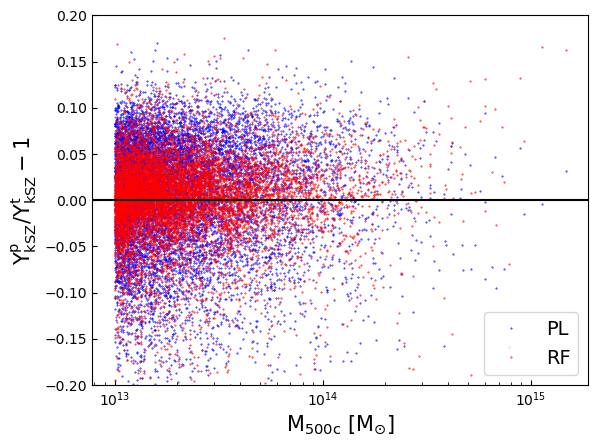

In [32]:
plt.plot(m500c,lnYksz_pl/lnYksz-1.,'b.',markersize=0.8,label='PL')
plt.plot(np.exp(lnX.T[0]),lnYksz_P/lnYksz-1.,'r.',markersize=0.8,label='RF')
plt.axhline(0.,c='k')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\rm M_{500c}\,\, [M_{\odot}]$',fontsize=15)
plt.ylabel(r'$\rm Y^{p}_{kSZ}/Y^{t}_{kSZ}-1$',fontsize=15)
plt.ylim(-0.2,0.2)
plt.tick_params(axis="both",direction="in",which="both")
plt.legend(loc='best',fontsize=14)
plt.show()